In [1]:
import os
import glob as glob
import timecorr as tc
import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.decomposition import PCA, IncrementalPCA
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
import statsmodels.api as sm 
import statsmodels
import matplotlib.pyplot as plt
%matplotlib inline  
import timecorr as tc
from timecorr.helpers import isfc, wisfc, mean_combine, corrmean_combine
import supereeg as se

In [2]:
def rbf(centers, widths, locs):
    """
    Radial basis function
    Parameters
    ----------
    centers : ndarray
        rbf coordinates (one row per RBF)
    widths : ndarray
        RBF radii
    locs : ndarray
        locations to evaluate the RBFs (one row per location)
        
    Returns
    ----------
    results : ndarray
        Matrix of RBF weights for each RBF (row), at each location (column)
    """    
    weights = np.exp(np.divide(-cdist(locs, centers, metric='euclidean') ** 2, np.tile(np.array(widths, ndmin=2), [locs.shape[0], 1])))
    return weights.T

In [3]:
def largest_indices(ary, n):
    """Returns the n largest indices from a numpy array."""
    flat = ary.flatten()
    indices = np.argpartition(flat, -n)[-n:]
    indices = indices[np.argsort(-flat[indices])]
    return np.unravel_index(indices, ary.shape)

In [4]:
def reduce_list(x, model):
    split = np.cumsum([len(xi) for xi in x])[:-1]
    x_r = np.vsplit(model.fit_transform(np.vstack(x)), split)
    if len(x) > 1:
        return [xi for xi in x_r]
    else:
        return [x_r[0]]

In [5]:
def regress(data, yvar, xvars):
    Y = data[yvar]
    X = data[xvars]
    X['intercept'] = 1.
    result = sm.OLS(Y, X).fit()
    return result.params

In [6]:
datadir = os.path.join(os.getenv('HOME'), 'Desktop', 'pca_env', 'pca_paper', 'pieman', 'data')


In [7]:
figdir = '../figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

In [8]:
nii_bo_dir = '../../data/niis'

In [9]:
pca_nii_bo_dir = os.path.join(nii_bo_dir, 'pcas')
if not os.path.exists(pca_nii_bo_dir):
    os.makedirs(pca_nii_bo_dir)

In [10]:
neurosynth_dir ='../figs/neurosynth_data/'
if not os.path.exists(neurosynth_dir):
    os.mkdir(neurosynth_dir)

In [11]:
n_f_dir = os.path.join(neurosynth_dir, 'figs')
if not os.path.exists(n_f_dir):
    os.mkdir(n_f_dir)
nii_dir = os.path.join(neurosynth_dir, 'niis')
if not os.path.exists(nii_dir):
    os.mkdir(nii_dir)
txt_dir = os.path.join(neurosynth_dir, 'txts')
if not os.path.exists(txt_dir):
    os.mkdir(txt_dir)
p_txt_dir = os.path.join(txt_dir, 'parsed_txts')
if not os.path.exists(p_txt_dir):
    os.mkdir(p_txt_dir)

In [12]:
ddir = '../../data/'

In [13]:
#figdir = '/Users/lucyowen/Desktop/timecorr_env/timecorr_paper/pieman/figs'

In [14]:
#results_dir = os.path.join(os.getenv('HOME'), 'Desktop', 'timecorr_env', 'timecorr_paper', 'pieman', 'results')
results_dir = os.path.join('../../data/', 'results')

In [15]:
posterior = loadmat(os.path.join(ddir, 'pieman_posterior_K700.mat'))
centers = posterior['posterior']['centers'][0][0][0][0][0]
widths = np.array(list(posterior['posterior']['widths'][0][0][0][0][0][:, 0].T))

In [16]:
template = se.helpers._gray(res=2)

In [17]:
factors=700

In [18]:
if factors == 100:
    pieman_name = '../../data/pieman_ica100.mat'
else:
    pieman_name = '../../data/pieman_data.mat'

pieman_conds = ['intact', 'paragraph', 'word', 'rest']

In [19]:
pieman_data = loadmat(pieman_name)

In [20]:
debug = False

In [21]:
if debug:
    data = []
    conds = []
    for c in pieman_conds:
        next_data = list(map(lambda i: pieman_data[c][:, i][0][:30, :10], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

else:

    data = []
    conds = []
    for c in pieman_conds:
        if c == 'paragraph':
            if factors == 700:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 3)[0]))
            else:
                next_data = list(map(lambda i: pieman_data[c][:, i][0], np.where(np.arange(pieman_data[c].shape[1]) != 0)[0]))
        else:
            next_data = list(map(lambda i: pieman_data[c][:, i][0], np.arange(pieman_data[c].shape[1])))
        data.extend(next_data)
        conds.extend([c]*len(next_data))
    del pieman_data

In [22]:
data = np.array(data)
conds = np.array(conds)

## pieman pca decoding

In [23]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100'

In [24]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [25]:
conds

['/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/intact.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/paragraph.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/rest.csv',
 '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode/PCA/ndims_100/word.csv']

In [26]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [27]:
full_data.head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.805733,0.003333,0.488089,1,0,0,intact
1,0,0.709222,0.013333,0.329000,2,0,0,intact
2,0,0.726200,0.013333,0.309211,3,0,0,intact
3,0,0.816556,0.040000,0.258333,4,0,0,intact
4,0,0.869389,0.066667,0.241333,5,0,0,intact


In [28]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,condition
0,0,0.805733,0.003333,0.488089,1,0,0,intact
1,0,0.709222,0.013333,0.329000,2,0,0,intact
2,0,0.726200,0.013333,0.309211,3,0,0,intact
3,0,0.816556,0.040000,0.258333,4,0,0,intact
4,0,0.869389,0.066667,0.241333,5,0,0,intact


In [29]:
outfile = os.path.join(figdir, 'Accuracy_by_components.pdf')

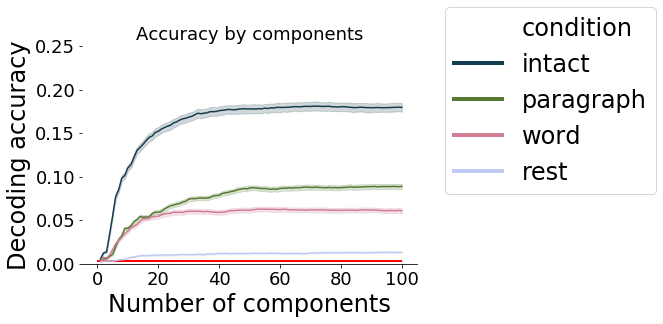

In [30]:
fig, ax = plt.subplots()
sns.lineplot(x="dims", y="accuracy",
             hue="condition",
             data=full_data, ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
ax.set_title('Accuracy by components')
ax.set_ylabel('Decoding accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)
ax.set_ylim(0, .25)
ax.hlines(y=1/300, xmin=0, xmax=100, linewidth=2, color='r')
#ax.legend(loc='center right', bbox_to_anchor=(1.6, 0.75), ncol=1)
l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')

In [32]:
def func(x, a, b, c, d, g):

    return (((a-d)/((1+((x/c)** b))**g)) + d )

In [33]:
hill = []
maxs = []
spearmans = []

ydata = full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
xdata = np.array(full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

popt, pcov = curve_fit(func, xdata, ydata)
hill.append(popt[1])

max_i = ydata.max()
maxs.append(max_i)

max_loc = np.where(ydata==max_i)[0][0]

max_p = full_data[full_data['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
max_w = full_data[full_data['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
max_r = full_data[full_data['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


spearmans.append(spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0])


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [45]:
popt[1]

1.8082404289275942

In [ ]:

slope_loc = np.where(ydata==max_i)[0][0]

In [216]:
popt[2]

7.7946266887653755

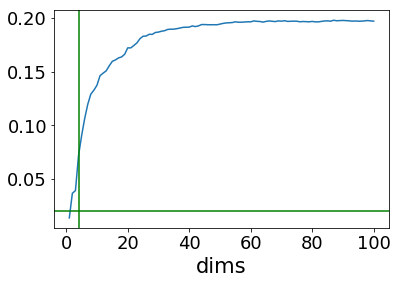

In [393]:
full_data[full_data['condition']=='intact'].groupby('dims')['accuracy'].mean().plot()
plt.plot(xdata, func(xdata, *popt), 'r-')
plt.axhline(y=popt[3], color='g', linestyle='-')
plt.axvline(x=popt[2], color='g', linestyle='-')
#plt.plot((0, 0), (20, 20*popt[1]), linewidth=4, color='r')
#plt.line(x=popt[1], y =20, color='g', linestyle='-')
#plt.axvline(x=popt[0], color='g', linestyle='-')
plt.show()

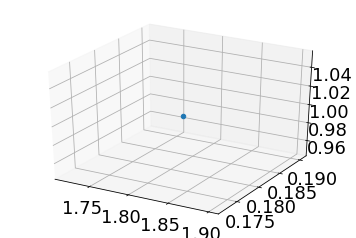

In [472]:
fig= plt.figure()
ax= fig.add_subplot(111, projection= '3d')
ax.scatter(hill,maxs,spearmans)

In [47]:
hill_all = np.zeros((4, 1, 4))
maxs_all = np.zeros((4, 1, 4))


In [52]:
max_loc = np.where(func(xdata, *popt)==popt[2])

In [65]:
func(xdata, *popt)

array([0.00093837, 0.01116257, 0.02462945, 0.03941026, 0.05415214,
       0.06804078, 0.08067358, 0.09191867, 0.10180123, 0.11042587,
       0.1179292 , 0.12445331, 0.13013236, 0.13508681, 0.1394217 ,
       0.14322715, 0.14657972, 0.14954411, 0.15217491, 0.1545181 ,
       0.15661255, 0.15849107, 0.16018151, 0.16170754, 0.16308935,
       0.16434423, 0.165487  , 0.16653045, 0.16748563, 0.16836212,
       0.16916826, 0.16991134, 0.17059773, 0.17123303, 0.17182216,
       0.1723695 , 0.17287889, 0.17335376, 0.17379717, 0.17421184,
       0.1746002 , 0.17496445, 0.17530653, 0.17562823, 0.17593114,
       0.17621669, 0.17648621, 0.17674086, 0.17698175, 0.17720983,
       0.17742602, 0.17763114, 0.17782592, 0.17801107, 0.1781872 ,
       0.17835491, 0.17851472, 0.17866713, 0.17881259, 0.17895152,
       0.17908432, 0.17921133, 0.1793329 , 0.17944934, 0.17956093,
       0.17966794, 0.17977062, 0.17986921, 0.17996392, 0.18005495,
       0.1801425 , 0.18022674, 0.18030784, 0.18038595, 0.18046

In [64]:
np.where(np.abs(xdata - popt[2]).min()

0.20537331123462454

In [62]:
popt[2]

7.7946266887653755

In [190]:
np.arange(20).reshape((10,2)).shape

(10, 2)

In [222]:
popt[3]

0.18359337668465975

In [488]:
import math
p1 = single_point
p2 = points
#distance = math.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )
find_m = (p1[1]-p2[1])/(p1[0]-p2[0])

In [489]:
distances = []
for p in points:
    distance = math.sqrt( ((p[0]-p[0])**2)+((p1[1]-p[1])**2) )
    distances.append(distance)

In [516]:
single_point

array([5.58053208, 0.20191601])

In [517]:
ms = []
for p in points:
    distance = (p[1] - p1[1])/(p[0] - p1[0])
    ms.append(distance)

In [518]:
ms

[0.2597132849801427,
 0.32674204146348074,
 0.4454193711582851,
 0.7153360842228681,
 1.9193499155374605,
 -2.6231549891438823,
 -0.7669088033545001,
 -0.44585439306934127,
 -0.31302987486843675,
 -0.24059990171678053,
 -0.19509054391145783,
 -0.16389230048893075,
 -0.14119857569383323,
 -0.12396488518700263,
 -0.11044205808716143,
 -0.09955419040572853,
 -0.09060351950628537,
 -0.08311794372224586,
 -0.07676676688408457,
 -0.07131153775109604,
 -0.06657604473465088,
 -0.062427294009846854,
 -0.05876305329765481,
 -0.0555034632090907,
 -0.05258524781400476,
 -0.04995763184362623,
 -0.047579405656956744,
 -0.04541677877432768,
 -0.04344178566323908,
 -0.041631085012475706,
 -0.03996504379355417,
 -0.0384270303953592,
 -0.037002863261338816,
 -0.03568037657802358,
 -0.03444907504918357,
 -0.03329985716690891,
 -0.032224791650096694,
 -0.03121693551653101,
 -0.0302701850256354,
 -0.029379152773364458,
 -0.02853906574411874,
 -0.02774568027037476,
 -0.0269952107200684,
 -0.0262842693967911

In [491]:
np.where(np.array((distances)) == np.array((distances)).min())

(array([99]),)

In [434]:
distance

0.15646665599104018

In [504]:


def euclid_dist(t1, t2):
    return np.sqrt(np.sum((t1-t2)**2,axis=1))  

import numpy as np
single_point = np.array((popt[2], popt[3]))
points = np.vstack((np.atleast_2d(xdata), np.atleast_2d(func(xdata, *popt)))).T  
distance = euclid_dist(single_point,points)

In [505]:
single_point 

array([5.58053208, 0.20191601])

In [506]:
b = 1.2 + 5.5

In [507]:
b

6.7

In [508]:
x = np.linspace(-5,25,100)
y = -1*x+b

In [509]:
points

array([[1.00000000e+00, 1.22909712e-02],
       [2.00000000e+00, 3.20056430e-02],
       [3.00000000e+00, 5.24970275e-02],
       [4.00000000e+00, 7.13043735e-02],
       [5.00000000e+00, 8.76717984e-02],
       [6.00000000e+00, 1.01586651e-01],
       [7.00000000e+00, 1.13313565e-01],
       [8.00000000e+00, 1.23185607e-01],
       [9.00000000e+00, 1.31520392e-01],
       [1.00000000e+01, 1.38592460e-01],
       [1.10000000e+01, 1.44629062e-01],
       [1.20000000e+01, 1.49814641e-01],
       [1.30000000e+01, 1.54297704e-01],
       [1.40000000e+01, 1.58197632e-01],
       [1.50000000e+01, 1.61610583e-01],
       [1.60000000e+01, 1.64614313e-01],
       [1.70000000e+01, 1.67272022e-01],
       [1.80000000e+01, 1.69635371e-01],
       [1.90000000e+01, 1.71746841e-01],
       [2.00000000e+01, 1.73641575e-01],
       [2.10000000e+01, 1.75348820e-01],
       [2.20000000e+01, 1.76893055e-01],
       [2.30000000e+01, 1.78294884e-01],
       [2.40000000e+01, 1.79571746e-01],
       [2.500000

In [510]:
single_point

array([5.58053208, 0.20191601])

In [511]:
np.where(distance==distance.min())

(array([5]),)

In [512]:
points

array([[1.00000000e+00, 1.22909712e-02],
       [2.00000000e+00, 3.20056430e-02],
       [3.00000000e+00, 5.24970275e-02],
       [4.00000000e+00, 7.13043735e-02],
       [5.00000000e+00, 8.76717984e-02],
       [6.00000000e+00, 1.01586651e-01],
       [7.00000000e+00, 1.13313565e-01],
       [8.00000000e+00, 1.23185607e-01],
       [9.00000000e+00, 1.31520392e-01],
       [1.00000000e+01, 1.38592460e-01],
       [1.10000000e+01, 1.44629062e-01],
       [1.20000000e+01, 1.49814641e-01],
       [1.30000000e+01, 1.54297704e-01],
       [1.40000000e+01, 1.58197632e-01],
       [1.50000000e+01, 1.61610583e-01],
       [1.60000000e+01, 1.64614313e-01],
       [1.70000000e+01, 1.67272022e-01],
       [1.80000000e+01, 1.69635371e-01],
       [1.90000000e+01, 1.71746841e-01],
       [2.00000000e+01, 1.73641575e-01],
       [2.10000000e+01, 1.75348820e-01],
       [2.20000000e+01, 1.76893055e-01],
       [2.30000000e+01, 1.78294884e-01],
       [2.40000000e+01, 1.79571746e-01],
       [2.500000

In [513]:
single_point 

array([5.58053208, 0.20191601])

In [514]:
np.atleast_2d(single_point)

array([[5.58053208, 0.20191601]])

In [515]:
points[:, 0]

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,
        78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,
        89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.,
       100.])

In [459]:
np.linspace(0,25,100)

array([ 0.        ,  0.25252525,  0.50505051,  0.75757576,  1.01010101,
        1.26262626,  1.51515152,  1.76767677,  2.02020202,  2.27272727,
        2.52525253,  2.77777778,  3.03030303,  3.28282828,  3.53535354,
        3.78787879,  4.04040404,  4.29292929,  4.54545455,  4.7979798 ,
        5.05050505,  5.3030303 ,  5.55555556,  5.80808081,  6.06060606,
        6.31313131,  6.56565657,  6.81818182,  7.07070707,  7.32323232,
        7.57575758,  7.82828283,  8.08080808,  8.33333333,  8.58585859,
        8.83838384,  9.09090909,  9.34343434,  9.5959596 ,  9.84848485,
       10.1010101 , 10.35353535, 10.60606061, 10.85858586, 11.11111111,
       11.36363636, 11.61616162, 11.86868687, 12.12121212, 12.37373737,
       12.62626263, 12.87878788, 13.13131313, 13.38383838, 13.63636364,
       13.88888889, 14.14141414, 14.39393939, 14.64646465, 14.8989899 ,
       15.15151515, 15.4040404 , 15.65656566, 15.90909091, 16.16161616,
       16.41414141, 16.66666667, 16.91919192, 17.17171717, 17.42

In [497]:
x = np.linspace(popt[2],6,10)

In [498]:
-1*x+(popt[3] + popt[2])

array([ 0.20191601,  0.15530846,  0.10870091,  0.06209337,  0.01548582,
       -0.03112173, -0.07772927, -0.12433682, -0.17094436, -0.21755191])

In [476]:
x = np.linspace(popt[2],3,100)
y = -1*x+(popt[3] + popt[2])

In [477]:
popt[3]

0.20191600579167152

In [478]:
popt[2]

5.580532084521052

In [521]:
try_x = np.linspace(0,50,100)

In [528]:
np.degrees(np.arctan((func(try_x, *popt) - .2) / (try_x- 5.5))) + 45

array([ 47.08135792,  47.24129336,  47.39168222,  47.55636304,
        47.75704418,  48.02336276,  48.40403493,  48.99332999,
        50.01119002,  52.13307746,  58.93956494, -16.95993384,
        35.11962   ,  40.09074934,  41.86854235,  42.7709327 ,
        43.31128658,  43.66779057,  43.91851341,  44.10302037,
        44.24348034,  44.35326333,  44.44089985,  44.51208014,
        44.57073902,  44.61967963,  44.66094936,  44.69607583,
        44.7262199 ,  44.75227794,  44.77495189,  44.79479832,
        44.81226347,  44.82770869,  44.8414293 ,  44.85366859,
        44.86462852,  44.8744779 ,  44.88335874,  44.89139117,
        44.89867741,  44.90530485,  44.91134858,  44.91687338,
        44.9219354 ,  44.92658346,  44.9308602 ,  44.93480298,
        44.93844464,  44.94181413,  44.94493706,  44.94783613,
        44.95053154,  44.9530413 ,  44.9553815 ,  44.95756654,
        44.95960937,  44.96152164,  44.96331383,  44.96499543,
        44.96657501,  44.96806037,  44.96945857,  44.97

In [ ]:
np.arctan2(y, x) * 180 / np.pi

In [530]:
func(20, *popt)

0.17364157518627643

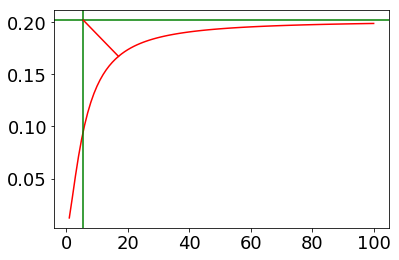

In [535]:
plt.plot(xdata, func(xdata, *popt), 'r-')
plt.axhline(y=popt[3], color='g', linestyle='-')
plt.axvline(x=popt[2], color='g', linestyle='-')
#plt.axvline(x=12, color='g', linestyle='-')
plt.plot([popt[2], 17], [popt[3], func(17, *popt)] , '-r', label='y=2x+1')

In [541]:
math.sqrt( ((popt[2]-17)**2)+((popt[3]-func(17, *popt))**2) )

11.419520466214099

In [542]:
math.sqrt( ((popt[2]-7)**2)+((popt[3]-func(7, *popt))**2) )

1.4222304860779877

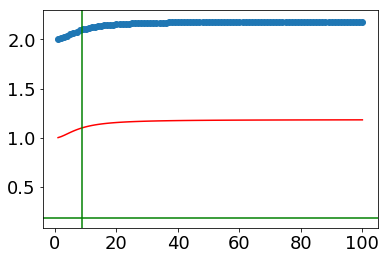

In [291]:
plt.scatter(points[:, 0], points[:, 1])
plt.plot(xdata, func(xdata, *popt), 'r-')
plt.axhline(y=popt[3], color='g', linestyle='-')
plt.axvline(x=popt[2], color='g', linestyle='-')

In [259]:

a = np.random.normal(size=(10,2))
b = np.random.normal(size=(1,2))

dist = scipy.spatial.distance.cdist(np.atleast_2d(single_point),points)

In [262]:
dist[:, 20]

array([13.20540087])

In [232]:
dist

array([[2.42624397],
       [3.03139051],
       [0.98840987],
       [1.92504371],
       [0.19104842],
       [2.10250541],
       [2.42241572],
       [1.51301995],
       [2.69666793],
       [1.30488486]])

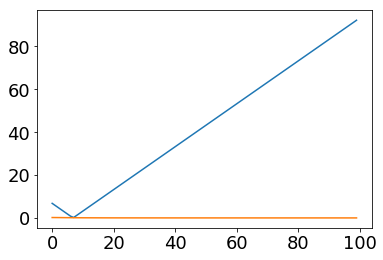

In [224]:
plt.plot(distance)

In [217]:
from scipy.spatial import distance

In [283]:
distance.cdist(single_point, points, 'euclidean')

ValueError: XA must be a 2-dimensional array.

In [214]:
np.where(distance==distance.min())

(array([7]),)

In [209]:
distance

array([ 6.79708134,  5.79719163,  4.79726116,  3.79736494,  2.79762281,
        1.79834295,  0.80126404,  0.22490542,  1.20814518,  2.20658671,
        3.20604583,  4.20578913,  5.20564784,  6.20556289,  7.2055087 ,
        8.2054726 ,  9.20544772, 10.20543011, 11.20541736, 12.20540794,
       13.20540087, 14.20539549, 15.20539133, 16.20538809, 17.20538553,
       18.20538349, 19.20538185, 20.20538052, 21.20537943, 22.20537853,
       23.20537779, 24.20537718, 25.20537666, 26.20537623, 27.20537586,
       28.20537554, 29.20537528, 30.20537505, 31.20537485, 32.20537468,
       33.20537453, 34.2053744 , 35.20537429, 36.20537419, 37.2053741 ,
       38.20537402, 39.20537396, 40.2053739 , 41.20537384, 42.20537379,
       43.20537375, 44.20537371, 45.20537368, 46.20537365, 47.20537362,
       48.2053736 , 49.20537357, 50.20537355, 51.20537353, 52.20537352,
       53.2053735 , 54.20537349, 55.20537348, 56.20537346, 57.20537345,
       58.20537344, 59.20537343, 60.20537343, 61.20537342, 62.20

In [200]:
points = np.arange(20).reshape((10,2))   
points.shape

(10, 2)

In [202]:
np.vstack((np.atleast_2d(xdata), np.atleast_2d(func(xdata, *popt))))

(2, 100)

In [282]:
from scipy.spatial import distance
a = (popt[3],popt[2])
b = (xdata, func(xdata, *popt))

distance = euclid_dist(a, b)

TypeError: unsupported operand type(s) for -: 'tuple' and 'tuple'

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


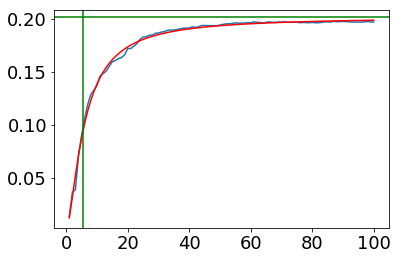

<Figure size 432x288 with 0 Axes>

In [395]:
#conditions = ['intact', 'paragraph', 'word', 'rest']
conditions = ['intact']
for e, c in enumerate(conditions):
    
    ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)
    
    hill_all[e, 0, 0] = popt[1]
    
    maxs_all[e, 0, 0] = ydata.max()
    

    plt.plot(xdata, ydata)
    plt.plot(xdata, func(xdata, *popt), 'r-')
    plt.axhline(y=popt[3], color='g', linestyle='-')
    plt.axvline(x=popt[2], color='g', linestyle='-')
    #plt.plot((0, 0), (20, 20*popt[1]), linewidth=4, color='r')
    #plt.line(x=popt[1], y =20, color='g', linestyle='-')
    #plt.axvline(x=popt[0], color='g', linestyle='-')
    plt.show()
    plt.clf()

In [105]:
popt

array([-3.49609219e-03,  1.80824043e+00,  7.79462669e+00,  1.83593377e-01,
        9.94983485e-01])

In [104]:
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(xdata, func(xdata, *popt))

In [129]:
spline

In [102]:
spline.derivatives(0)

ValueError: Error code returned by spalde: 10

In [103]:
x = np.linspace(0, 3, 11)
y = x**2
spl = UnivariateSpline(x, y)
spl.derivatives(0)



array([ 2.36795739e-16, -2.36795739e-16,  2.00000000e+00,  0.00000000e+00])

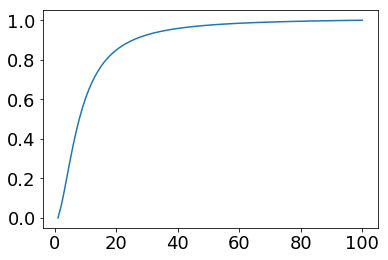

In [278]:
plt.plot(xdata, (func(xdata, *popt)-func(xdata, *popt).min())/(func(xdata, *popt).max()-func(xdata, *popt).min()), label="y")




In [106]:
spline(xdata, 1).max()

0.008217679182541349

In [112]:
np.abs(spline(xdata, 1) - spline(xdata, 1).max())

array([0.        , 0.00028095, 0.00055735, 0.00082918, 0.00109644,
       0.00135915, 0.00161729, 0.00187087, 0.00211989, 0.00236435,
       0.00260425, 0.00283958, 0.00307035, 0.00329656, 0.0035182 ,
       0.00373528, 0.00394781, 0.00415577, 0.00435916, 0.004558  ,
       0.00475227, 0.00494198, 0.00512713, 0.00530771, 0.00548374,
       0.0056552 , 0.0058221 , 0.00598444, 0.00614221, 0.00629542,
       0.00644407, 0.00658816, 0.00672769, 0.00686265, 0.00699305,
       0.00711889, 0.00724017, 0.00735689, 0.00746904, 0.00757663,
       0.00767966, 0.00777813, 0.00787203, 0.00796137, 0.00804615,
       0.00812637, 0.00820202, 0.00827312, 0.00833965, 0.00840162,
       0.00845902, 0.00851187, 0.00856015, 0.00860387, 0.00864303,
       0.00867762, 0.00870766, 0.00873313, 0.00875404, 0.00877038,
       0.00878217, 0.00878939, 0.00879205, 0.00879015, 0.00878368,
       0.00877266, 0.00875707, 0.00873692, 0.0087122 , 0.00868293,
       0.00864909, 0.00861069, 0.00856773, 0.00852021, 0.00846

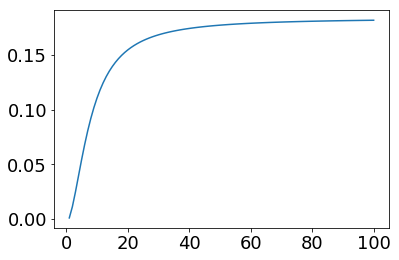

In [350]:
plt.plot(xdata, func(xdata, *popt), label='data')

In [386]:
def n_derivative(arr, degree=1):
    """Compute the n-th derivative."""
    result = arr.copy()
    for i in range(degree):
        result = np.gradient(result)
    return result


def close_zero(arr, threshold=1e-4):
    return (abs(arr) < threshold)

def maxima_2(arr):
    return close_zero(n_derivative(arr, 2)) & (n_derivative(arr, 3) > 0)


In [387]:
maxima_2(y)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

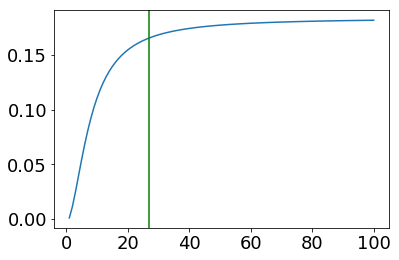

In [361]:
plt.plot(xdata, func(xdata, *popt), label='data')
plt.axvline(x=xdata[maxima_2(y)].min(), color='g', linestyle='-')

In [131]:
import scipy as sp
import scipy.interpolate
f = sp.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')

In [133]:
x = xdata
y = f(x)

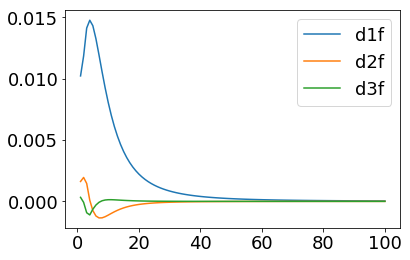

In [311]:
plt.figure()
plt.plot(xdata, func(xdata, *popt), label='data')
plt.plot(x, y, label='f')
plt.plot(x, n_derivative(y, 1), label='d1f')
plt.plot(x, n_derivative(y, 2), label='d2f')
plt.plot(x, n_derivative(y, 3), label='d3f')
plt.legend()
for w in np.where(maxima(y))[0]:
    plt.axvline(x=x[w])
plt.show()

In [316]:
from scipy.signal import argrelextrema

In [337]:
maxima_2(y)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [335]:
n_derivative(y, 3)

array([ 3.28484253e-04, -8.17155329e-05, -9.27054201e-04, -1.10410692e-03,
       -6.41932975e-04, -2.99068500e-04, -7.72591807e-05,  4.92633540e-05,
        1.11367322e-04,  1.34360960e-04,  1.35728618e-04,  1.26371043e-04,
        1.12596023e-04,  9.78139466e-05,  8.37231456e-05,  7.10607566e-05,
        6.00508344e-05,  5.06607336e-05,  4.27425890e-05,  3.61084024e-05,
        3.05678350e-05,  2.59456000e-05,  2.20880417e-05,  1.88642363e-05,
        1.61645175e-05,  1.38979729e-05,  1.19896952e-05,  1.03781686e-05,
        9.01294362e-06,  7.85264842e-06,  6.86332472e-06,  6.01705542e-06,
        5.29084284e-06,  4.66569650e-06,  4.12589376e-06,  3.65838123e-06,
        3.25229037e-06,  2.89854508e-06,  2.58954364e-06,  2.31890020e-06,
        2.08123449e-06,  1.87200018e-06,  1.68734453e-06,  1.52399332e-06,
        1.37915623e-06,  1.25044883e-06,  1.13582810e-06,  1.03353904e-06,
        9.42070153e-07,  8.60116504e-07,  7.86548732e-07,  7.20387140e-07,
        6.60779912e-07,  

In [333]:
from numpy import *

a = diff(sign(diff(n_derivative(y, 2)[7:]))).nonzero()[0] + 1 # local min+max
b = (diff(sign(diff(n_derivative(y, 2)[7:]))) > 0).nonzero()[0] + 1 # local min
c = (diff(sign(diff(n_derivative(y, 2)[7:]))) < 0).nonzero()[0] + 1 # local max


NameError: name 'legend' is not defined

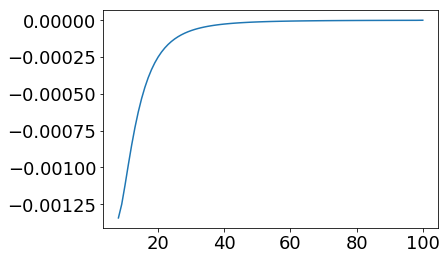

In [334]:
plt.plot(xdata[7:],n_derivative(y, 2)[7:])
plt.plot(xdata[7:][b], n_derivative(y, 2)[7:][b], "o", label="min")
plt.plot(xdata[7:][c], n_derivative(y, 2)[7:][c], "o", label="max")
legend()
show()

In [315]:
zeroes(n_derivative(y, 2))

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [309]:
n_derivative(y, 2).min()

-0.0013484482073795913

In [307]:
np.where(np.abs(n_derivative(y, 2)).min() == np.abs(n_derivative(y, 2)))

(array([99]),)

In [305]:
np.where(zeroes(n_derivative(y, 2)))

(array([4]),)

In [ ]:
from scipy.optimize import fsolve
grad = sym.lambdify((x, y), gradient)
fsolve(lambda v: grad(v[0], v[1]), (1, 2))

In [168]:
from scipy.ndimage import rank_filter

def find_local_maxima(x):
    x_dilate = rank_filter(x, -1, size=3)
    return x_dilate == x

In [ ]:

plt.plot(xdata, (spline(xdata)-spline(xdata).min())/(spline(xdata).max()-spline(xdata).min()), label="y2")
plt.plot(xdata, (spline(xdata, 1)-spline(xdata, 1).min())/(spline(xdata, 1).max()-spline(xdata, 1).min()), label="y2'")
plt.plot(xdata, (spline(xdata, 2)-spline(xdata, 2).min())/(spline(xdata, 2).max()-spline(xdata, 2).min()), label="y2''")
plt.plot(xdata, (spline(xdata, 3)-spline(xdata, 3).min())/(spline(xdata, 3).max()-spline(xdata, 3).min()), label="y2'''")
plt.axvline(x=popt[2], color='g', linestyle='-')
plt.axvline(x=7, color='g', linestyle='-')
plt.legend()
plt.show()

In [113]:
from scipy import optimize

In [122]:
def f(x):

    return (((-3.49609219e-03-1.83593377e-01)/((1+((x/7.79462669e+00)** 1.80824043e+00))**9.94983485e-01)) + 1.83593377e-01 )

In [121]:
popt

array([-3.49609219e-03,  1.80824043e+00,  7.79462669e+00,  1.83593377e-01,
        9.94983485e-01])

In [118]:
func(xdata, *popt)

array([0.00093837, 0.01116257, 0.02462945, 0.03941026, 0.05415214,
       0.06804078, 0.08067358, 0.09191867, 0.10180123, 0.11042587,
       0.1179292 , 0.12445331, 0.13013236, 0.13508681, 0.1394217 ,
       0.14322715, 0.14657972, 0.14954411, 0.15217491, 0.1545181 ,
       0.15661255, 0.15849107, 0.16018151, 0.16170754, 0.16308935,
       0.16434423, 0.165487  , 0.16653045, 0.16748563, 0.16836212,
       0.16916826, 0.16991134, 0.17059773, 0.17123303, 0.17182216,
       0.1723695 , 0.17287889, 0.17335376, 0.17379717, 0.17421184,
       0.1746002 , 0.17496445, 0.17530653, 0.17562823, 0.17593114,
       0.17621669, 0.17648621, 0.17674086, 0.17698175, 0.17720983,
       0.17742602, 0.17763114, 0.17782592, 0.17801107, 0.1781872 ,
       0.17835491, 0.17851472, 0.17866713, 0.17881259, 0.17895152,
       0.17908432, 0.17921133, 0.1793329 , 0.17944934, 0.17956093,
       0.17966794, 0.17977062, 0.17986921, 0.17996392, 0.18005495,
       0.1801425 , 0.18022674, 0.18030784, 0.18038595, 0.18046

In [123]:
grid = (0, 10, 0.1)
xmin_global = optimize.brute(f, (grid, ))

In [124]:
xmin_global

array([0.])

In [127]:
xmin_local = optimize.fminbound(f, 1, 30)

In [128]:
xmin_local

1.0000059537899673

In [81]:
np.where(np.abs(spline(xdata, 1)).min() == np.abs(spline(xdata, 1)))

(array([99]),)

In [77]:
spline(xdata, 2).min()

-0.0014001873027417984

In [378]:
conditions = ['intact', 'paragraph', 'word', 'rest']
#conditions = ['intact']
for e, c in enumerate(conditions):
    
    ydata = full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data[full_data['condition']==c].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)
    
    f = sp.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
    y = f(xdata)
    
    hill_all[e, 0, 0] = xdata[maxima_2(y)].min()
    
    maxs_all[e, 0, 0] = func(xdata[maxima_2(y)].min(), *popt)
    

#     plt.plot(xdata, ydata)
#     plt.plot(xdata, func(xdata, *popt), 'r-')
#     plt.axhline(y=popt[3], color='g', linestyle='-')
#     plt.axvline(x=popt[2], color='g', linestyle='-')
#     #plt.plot((0, 0), (20, 20*popt[1]), linewidth=4, color='r')
#     #plt.line(x=popt[1], y =20, color='g', linestyle='-')
#     #plt.axvline(x=popt[0], color='g', linestyle='-')
#     plt.show()
#     plt.clf()

/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [372]:
func(popt[2], *popt)

0.08972280390656745

In [368]:
np.where(

7.7946266887653755

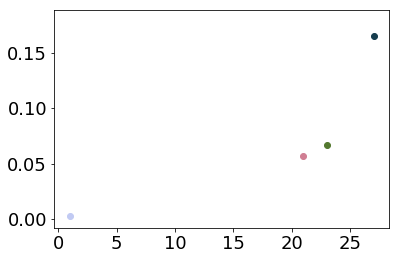

In [379]:
fig = plt.figure()
ax = fig.add_subplot(111)
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    plt.scatter(hill_all[e, :, 0],maxs_all[e, :, 0], 
                color=colors[e])

#markers=['o', '$1$', '$2$','$3$']
# for n in np.arange(len(network_list)):
#     for i in np.arange(4):
    
#         plt.scatter(hill_all[n, i],maxs_all[n, i], 
#                    marker=markers[i], s=100, color=color_stacked[n])


In [381]:
resultsdir = '/Users/lucyowen/Desktop/pca_env/pca_paper/pieman/results/pca_decode_chunked/PCA/ndims_100'

In [382]:
conds =glob.glob(os.path.join(resultsdir, '*.csv'))

In [383]:
full_data = pd.DataFrame()
for c in conds:
    data = pd.read_csv(c)
    data['condition'] = os.path.basename(os.path.splitext(c)[0])

    if full_data.empty:
        full_data = data
    else:
        full_data = full_data.append(data)

In [512]:
full_data[full_data['condition']=='intact'].head()

,Unnamed: 0,rank,accuracy,error,dims,folds,iteration,third,condition
0,0,0.7835,0.01,0.4538,1,0,0,0,intact
1,0,0.7149,0.03,0.3370,2,0,0,0,intact
2,0,0.7091,0.03,0.2867,3,0,0,0,intact
3,0,0.7379,0.04,0.2297,4,0,0,0,intact
4,0,0.8162,0.07,0.1967,5,0,0,0,intact


KeyboardInterrupt: 

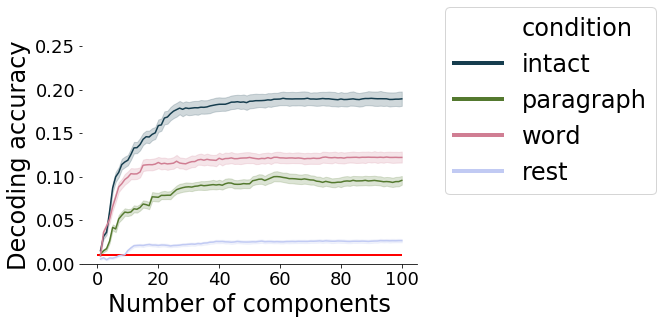

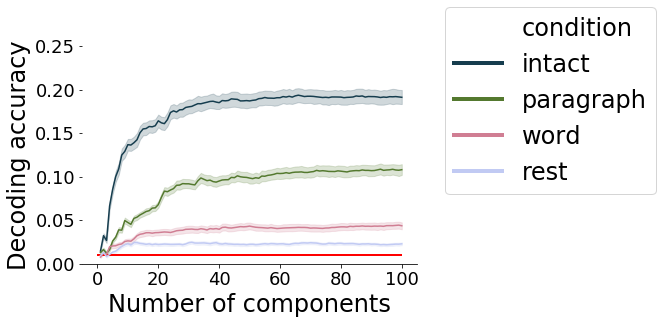

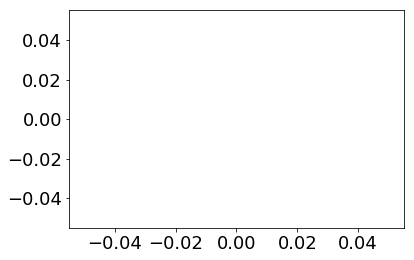

In [537]:
for i in range(3):
    outfile = os.path.join(figdir, 'Accuracy_by_components_third_' + str(i) + '.pdf')
    fig, ax = plt.subplots()
    sns.lineplot(x="dims", y="accuracy",
                 hue="condition",
                 data=full_data[full_data['third']==i], ax=ax, palette="cubehelix", hue_order=['intact', 'paragraph', 'word', 'rest'])
    sns.despine(ax=ax, left=True)
    #ax.set_title('Accuracy by components for third: ' + str(i + 1))
    ax.set_ylabel('Decoding accuracy',fontsize=24)
    ax.set_xlabel('Number of components',fontsize=24)
    ax.set_ylim(0, .25)
    ax.hlines(y=1/100, xmin=0, xmax=100, linewidth=2, color='r')
    l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
    for line in l.get_lines():
        line.set_linewidth(4.0)
    fig.savefig(outfile, bbox_inches='tight')
    

In [384]:
conditions = ['intact', 'paragraph', 'word', 'rest']

for i in np.arange(1, 4):
    
    full_data_temp = full_data[full_data['third']==i-1]

    for e, c in enumerate(conditions):


        ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
        xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

        popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)

        f = sp.interpolate.interp1d(xdata, func(xdata, *popt), 'cubic')
        y = f(xdata)

        hill_all[e, 0, i] = xdata[maxima_2(y)].min()

        maxs_all[e, 0, i] = func(xdata[maxima_2(y)].min(), *popt)


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [513]:
# conditions = ['intact', 'paragraph', 'word', 'rest']

# for i in np.arange(1, 4):
    
#     full_data_temp = full_data[full_data['third']==i-1]

#     for e, c in enumerate(conditions):


#         ydata = full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().as_matrix()
#         xdata = np.array(full_data_temp[full_data_temp['condition']==c].groupby('dims')['accuracy'].mean().index)

#         popt, pcov = curve_fit(func, xdata, ydata, maxfev=4000)

#         hill_all[e, 0, i] = popt[1]

#         maxs_all[e, 0, i] = ydata.max()


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [528]:
# try_it = maxs_all/hill_all

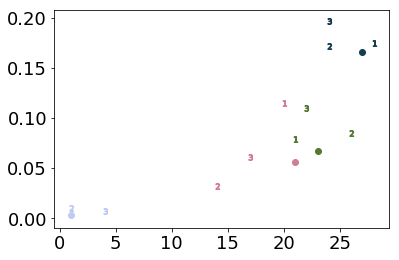

In [385]:
fig = plt.figure()
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    for i in np.arange(4):
        plt.scatter(hill_all[e, :, i],maxs_all[e, :, i], 
                    marker=markers[i], color=colors[e])

#markers=['o', '$1$', '$2$','$3$']
# for n in np.arange(len(network_list)):
#     for i in np.arange(4):
    
#         plt.scatter(hill_all[n, i],maxs_all[n, i], 
#                    marker=markers[i], s=100, color=color_stacked[n])


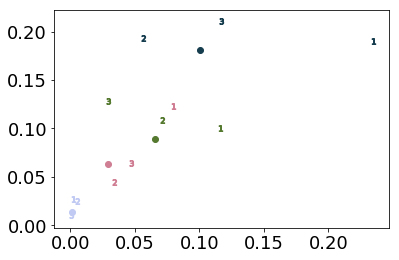

In [530]:
fig = plt.figure()
ax = fig.add_subplot(111)
markers=['o', '$1$', '$2$','$3$']
colors = sns.color_palette("cubehelix", 4)
for e, c in enumerate(conditions):
    for i in np.arange(4):
        plt.scatter(try_it[e, :, i],maxs_all[e, :, i], 
                    marker=markers[i], color=colors[e])

#markers=['o', '$1$', '$2$','$3$']
# for n in np.arange(len(network_list)):
#     for i in np.arange(4):
    
#         plt.scatter(hill_all[n, i],maxs_all[n, i], 
#                    marker=markers[i], s=100, color=color_stacked[n])


In [428]:
# hill = []
# maxs = []
# spearmans = []

for i in range(3):
    full_data_temp = full_data[full_data['third']==i]

    ydata = full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().as_matrix()
    xdata = np.array(full_data_temp[full_data_temp['condition']=='intact'].groupby('dims')['accuracy'].mean().index)

    popt, pcov = curve_fit(func, xdata, ydata)
    hill.append(popt[1])
    max_i = ydata.max()
    print(maxs)
    maxs.append(max_i)
    max_loc = np.where(ydata==max_i)[0][0]

    max_p = full_data_temp[full_data_temp['condition']=='paragraph'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
    max_w = full_data_temp[full_data_temp['condition']=='word'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]
    max_r = full_data_temp[full_data_temp['condition']=='rest'].groupby('dims')['accuracy'].mean().as_matrix()[max_loc]


    spearmans.append(spearmanr([4,3,2,1],[max_i,max_p,max_w,max_r])[0])


[0.18125]
[0.18125, 0.19034999999999996]
[0.18125, 0.19034999999999996, 0.19385000000000008]


/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/Users/lucyowen/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:20: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [429]:
maxs

[0.18125, 0.19034999999999996, 0.19385000000000008, 0.21135000000000012]

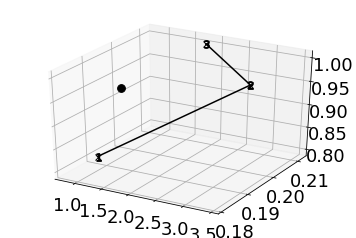

In [456]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
markers=['o', '$1$', '$2$','$3$']

ax.plot(hill[1:],maxs[1:],spearmans[1:],'x-', color='black')

for e, m in enumerate(markers):
    
    ax.scatter(hill[e],maxs[e],spearmans[e], marker=m, s=60, color='black')


In [457]:
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

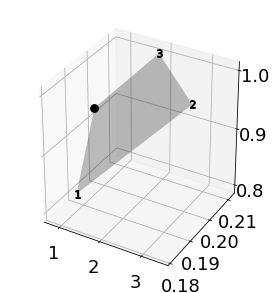

In [463]:
markers=['o', '$1$', '$2$','$3$']

plt.figure('SPLTV',figsize=(10,5))

custom=plt.subplot(121,projection='3d')

#custom.plot(hill[1:],maxs[1:],spearmans[1:],'x-', color='black')

for e, m in enumerate(markers):
    
    custom.scatter(hill[e],maxs[e],spearmans[e], marker=m, s=60, color='black')
    

#custom.scatter(hill, maxs, spearmans)
# 1. create vertices from points
verts = [list(zip(hill, maxs, spearmans))]
# 2. create 3d polygons and specify parameters
srf = Poly3DCollection(verts, alpha=.25, facecolor='black')
# 3. add polygon to the figure (current axes)
plt.gca().add_collection3d(srf)

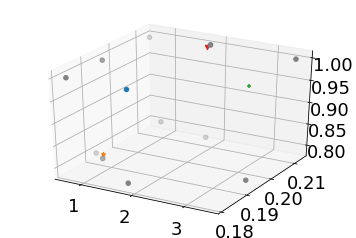

In [438]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
markers=['o', '*', '+','v']

for e, m in enumerate(markers):
    
    ax.scatter(hill[e],maxs[e],spearmans[e], marker=m)
    
xflat = np.full_like(hill, min(ax.get_xlim()))
yflat = np.full_like(maxs, max(ax.get_ylim()))
zflat = np.full_like(spearmans, min(ax.get_zlim()))

ax.scatter(xflat, maxs, spearmans, color='gray')
ax.scatter(hill, yflat, spearmans, color='gray')
ax.scatter(hill, maxs, zflat, color='gray')

In [39]:
data_regression = full_data.groupby(['iteration', 'folds', 'condition', 'dims'], 
                           group_keys=False).apply(regress, 'accuracy', ['third']).reset_index()

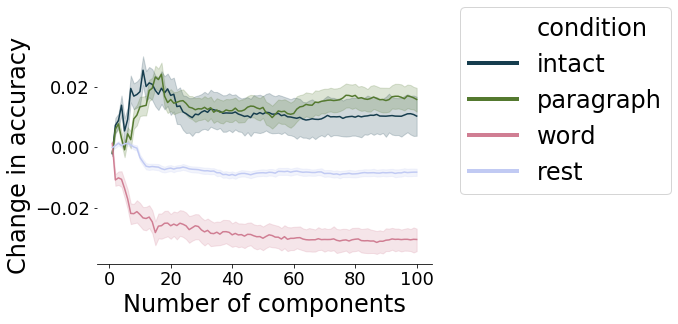

In [40]:
outfile = os.path.join(figdir, 'Changes_across_thirds.pdf')

fig, ax = plt.subplots()
sns.lineplot(x="dims", y="third",
             hue="condition",
             data=data_regression, palette="cubehelix", 
           hue_order=['intact', 'paragraph', 'word', 'rest'])
sns.despine(ax=ax, left=True)
#ax.set_title('Accuracy by components for third: ' + str(i + 1))
ax.set_ylabel('Change in accuracy',fontsize=24)
ax.set_xlabel('Number of components',fontsize=24)

l = ax.legend(loc='center right', bbox_to_anchor=(1.75, 0.75), ncol=1,fontsize=24)
for line in l.get_lines():
    line.set_linewidth(4.0)
fig.savefig(outfile, bbox_inches='tight')